# Probabilistic structures for scalable computing



## Online mean and variance estimates

The first technique we'll introduce isn't a probabilistic structure at all, but it will serve as a warm-up to introduce some of the more involved concepts we'll look at later.  We'll look at Chan's formula for online mean and variance estimates, so that we can calculate estimated mean and variance in a single pass over a large data set.  As we'll see, this technique will also let us combine estimates for several data sets (i.e., for processing a partitioned collection in parallel).

In [1]:
class StreamMV(object):
    from sys import float_info

    def __init__(self, count=0, min=float_info.max,
                 max=-float_info.max, m1=0.0, m2=0.0):
        (self.count, self.min, self.max) = (count, min, max)
        (self.m1, self.m2) = (m1, m2)

    def __lshift__(self, sample):
        (self.max, self.min) = (max(self.max, sample), min(self.min, sample))
        dev = sample - self.m1
        self.m1 = self.m1 + (dev / (self.count + 1))
        self.m2 = self.m2 + (dev * dev) * self.count / (self.count + 1)
        self.count += 1
        return self

    def mean(self): 
        return self.m1

    def variance(self): 
        return self.m2 / self.count

    def stddev(self): 
        return math.sqrt(self.variance)
    
    def merge_from(self, other):
        if other.count == 0:
            return self
        if self.count == 0:
            (self.m1, self.m2) = (other.m1, other.m2)
            self.count = other.count
            (self.min, self.max) = (other.min, other.max)
            return self
        else:
            dev = other.m1 - self.m1
            new_count = other.count + self.count
            self.m1 = (self.count * self.m1 + other.count * other.m1) / new_count
            self.m2 = self.m2 + other.m2 + (dev * dev) * self.count * other.count / new_count
            self.count = new_count
            self.max = max(self.max, other.max)
            self.min = min(self.min, other.min)
            return self

We can test this code by sampling from a random distribution with known mean and variance.  (We're using the Poisson distribution with a $\lambda$ parameter of 7, which should have a mean and variance of 7, but you could try with any other distribution if you wanted.)

In [2]:
from scipy.stats import poisson
sink = StreamMV()

for p in poisson.rvs(7, size=10000):
    sink << p

print (sink.mean(), sink.variance())

7.0361 6.99439679


We can see that we can also parallelize this work:

In [3]:
from scipy.stats import poisson
s1, s2 = StreamMV(), StreamMV()

for p in poisson.rvs(7, size=10000):
    s1 << p


for p in poisson.rvs(7, size=10000):
    s2 << p

print("s1 mean %f, variance %f, count %d" % (s1.mean(), s1.variance(), s1.count))
print("s2 mean %f, variance %f, count %d" % (s2.mean(), s2.variance(), s2.count))

s1.merge_from(s2)

print("s1+s2 mean %f, variance %f, count %d" % (s1.mean(), s1.variance(), s1.count))

s1 mean 7.004700, variance 7.007878, count 10000
s2 mean 6.983200, variance 6.977518, count 10000
s1+s2 mean 6.993950, variance 6.992813, count 20000


The mean and variance estimate technique we've just shown has a few things in common with the other techniques we'll look at:

1.  It's _incremental_, meaning that it is possible to update an estimate with a single sample at a time (this also implies that it's _single-pass_, meaning that you only need to see each sample once).
2.  It's _parallel_, meaning that it is possible to combine estimates for subsets of the population of interest and get an estimate for their union, and
3.  It's _scalable_, meaning that it requires a constant amount of space no matter how many samples it processes.

## Bloom filter

A conventional hash table (or hash table-backed set structure) consists of a series of _buckets_.  Hash table insert looks like this:

1.  First, use the hash value of the key to identify the index of the bucket that should contain it.  
2.  If the bucket is empty, update the bucket to contain the key and value (with a trivial value in the case of a hashed set).  
3.  If the bucket is not empty and the key stored in it is not the one you've hashed, handle this _hash collision_.  There are several strategies to handle hash collisions precisely; most involve extra lookups (e.g., having a second hash function or going to the next available bucket) or extra space (e.g., having a linked list of keys and values in each bucket).

Hash table lookup proceeds similarly:  

1.  Looking up the index of the bucket that should contain a key (as above).
2.  Check to see if that bucket contains the key.  
  - If the bucket contains the key, return the value (or "true" in the case of a hash-backed set).
  - If the bucket contains nothing, then the key is not in the table.  
  - If the bucket contains something else, follow the strategy for resolving collisions until finding a bucket that contains the key or exhausting all possible buckets.

Think of a [Bloom filter](https://en.wikipedia.org/wiki/Bloom_filter) as a hashed set structure that has no precise way to handle collisions.  Instead, the Bloom filter ameliorates the impact of hash collisions by using _multiple hash functions_.  The buckets in the Bloom filter are merely bits:  they do not have the identities of keys.  When a value is inserted into the Bloom filter, multiple hash functions are used to select which buckets should be set to true (buckets that are already true are not changed).  This means that if _all_ of the buckets for a given key are true, then the Bloom filter _may_ contain it, but that if _any_ of the buckets for a given key are false, then the Bloom filter _must not_ contain it.

Let's see an implementation.  We'll start by building a basic bit vector class so that we can efficiently store values.

In [4]:
import numpy

class BitVector(object):
    def __init__(self, size):
        self._size = size
        ct = size % 64 == 0 and (size / 64) or (size / 64 + 1)
        self._entries = numpy.zeros(int(ct), numpy.uint64)
    
    def __len__(self):
        return self._size
    
    def __getitem__(self, key):
        k = int(key)
        return (self._entries[int(k / 64)] & numpy.uint64(1 << (k % 64))) > 0
    
    def __setitem__(self, key, value):
        k = int(key)
        if value:
            update = numpy.uint64(1 << key % 64)
            self._entries[int(k / 64)] = self._entries[int(k / 64)] | update
        else:
            update = numpy.uint64(1 << key % 64)
            self._entries[int(k / 64)] = self._entries[int(k / 64)] ^ update
    
    def merge_from(self, other):
        numpy.bitwise_or(self._entries, other._entries, self._entries)
    
    def intersect_from(self, other):
        numpy.bitwise_and(self._entries, other._entries, self._entries)
    
    def dup(self):
        result = BitVector(self._size)
        result.merge_from(self)
        return result
    
    def intersect(self, other):
        result = BitVector(self._size)
        numpy.bitwise_and(self._entries, other._entries, result._entries)
        return result
    
    def union(self, other):
        result = BitVector(self._size)
        numpy.bitwise_or(self._entries, other._entries, result._entries)
        return result
    
    def count_set_bits(self):
        """ Count the number of bits set in this vector. 
            There are absolutely better ways to do this
            but this implementation is suitable for
            occasional use. """
        def set_bits(i):
            result = 0
            i = int(i)
            while i:
                result += (i & 1)
                i >>= 1
            return result
        return sum([set_bits(x) for x in self._entries])
        

We can now implement the Bloom filter using the bit vector to store values.

In [5]:
class Bloom(object):
    def __init__(self, size, hashes):
        """ Initializes a Bloom filter with the
            given size and a collection of hashes, 
            which are functions taking arbitrary 
            values and returning integers. 
            
            hashes can be either a function taking 
            a value and returning a list of results
            or a list of functions.  In the latter 
            case, this constructor will synthesize 
            the former """
        self.__buckets = BitVector(size)
        self.__size = len(self.__buckets)
        
        if hasattr(hashes, '__call__'):
            self.__hashes = hashes
        else:
            funs = hashes[:]
            def h(value):
                return [f(value) for f in funs]
            self.__hashes = h
    
    def size(self):
        return self.__size
    
    def insert(self, value):
        """ Inserts a value into this set """
        for h in self.__hashes(value):
            self.__buckets[h % self.__size] = True
    
    def lookup(self, value):
        """ Returns true if value may be in this set
            (i.e., may return false positives) """
        for h in self.__hashes(value):
            if self.__buckets[h % self.__size] == False:
                return False
        return True

Now we'll need some different hash functions to use in our Bloom filter.  We can simulate multiple hashes by using one of the hashes supplied in `hashlib` and simply masking out parts of the digest.

In [6]:
from hashlib import sha1
import pickle

def h_sha1(value):
    bvalue = type(value) == bytes and value or pickle.dumps(value)
    return sha1(bvalue).hexdigest()

def hashes_for(value):
    bvalue = type(value) == bytes and value or pickle.dumps(value)
    digest = sha1(bvalue).hexdigest()
    return [int(digest[s:s+7], 16) for s in [0,8,16,24]]

def h1(value):
    return int(h_sha1(value)[0:8], 16)

def h2(value):
    return int(h_sha1(value)[8:16], 16)

def h3(value):
    return int(h_sha1(value)[16:24], 16)

def hashes_for(count, stride):
    def hashes(value):
        bvalue = type(value) == bytes and value or pickle.dumps(value)
        digest = sha1(bvalue).hexdigest()
        return [int(digest[s:s+stride], 16) for s in [x * stride for x in range(count)]]
    return hashes

Now let's construct a Bloom filter using our three hashes.

In [7]:
# equivalent to bloom = Bloom(1024, [h1, h2, h3])
bloom = Bloom(1024, hashes_for(3, 8))

In [8]:
bloom.insert("foobar")
bloom.lookup("foobar")

True

In [9]:
bloom.lookup("absent")

False

So far, so good!  Now let's run an experiment to see how our false positive rate changes over time.  We're going to construct a random stream of values and insert them into a Bloom filter -- but we're going to look them up first.  Since it is extremely improbable that we'll get the same random values twice in a short simulation (the period of the Mersenne Twister that Python uses is too large to allow this), we can be fairly certain that any values for which `lookup` returns true before we've inserted them are false positives.  We'll collect the false positive rate at every 100 samples.

In [10]:
def bloom_experiment(sample_count, size, hashes, seed=0x15300625):
    import random
    from collections import namedtuple
   
    random.seed(seed)
    bloom = Bloom(size, hashes)
    
    result = []
    false_positives = 0
    
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if bloom.lookup(bits):
            false_positives = false_positives + 1
        bloom.insert(bits)
        
        if i % 100 == 0:
            result.append((i + 1, false_positives / float(i + 1)))
    result.append((i + 1, false_positives / float(i + 1)))
    return result

In [11]:
from pandas import DataFrame

results = bloom_experiment(1 << 18, 4096, hashes_for(3, 8))
df = DataFrame.from_records(results)
df.rename(columns={0: "unique values", 1: "false positive rate"}, inplace=True)

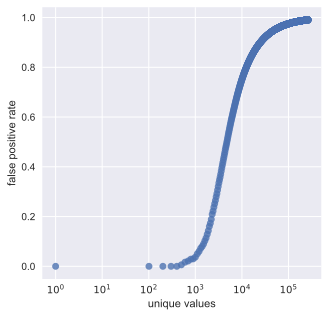

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(color_codes=True)
_, ax = plt.subplots(figsize=(5,5))
ax.set(xscale="log")

_ = sns.regplot("unique values", "false positive rate", df, ax=ax, fit_reg=False, scatter=True)

We can see how increasing the size of the filter changes our results:

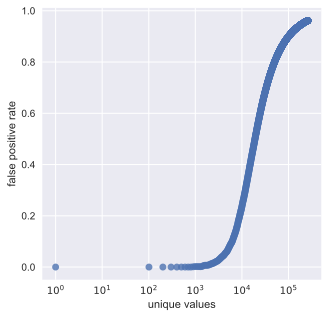

In [13]:
results = bloom_experiment(1 << 18, 16384, hashes_for(3, 8))
df = DataFrame.from_records(results )
df.rename(columns={0: "unique values", 1: "false positive rate"}, inplace=True)
_, ax = plt.subplots(figsize=(5,5))
ax.set(xscale="log")


_ = sns.regplot("unique values", "false positive rate", df, ax=ax, fit_reg=False, scatter=True)

### Analytic properties

We can analytically predict a false positive rate for a given Bloom filter.  If $k$ is the number of hash functions, $m$ is the size of the Bloom filter in bits, and $n$ is the number of elements in the set, we can expect a false positive rate of $ ( 1 - e^{- kn / m} )^k $.  Let's plot that function for our previous example:

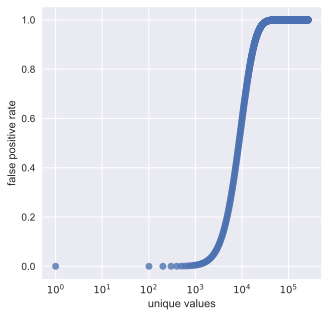

In [14]:
results = []
import math
hash_count = 3
filter_size = 16384

entries = 0
while entries < 1 << 18:
    results.append((entries + 1, math.pow(1 - math.pow(math.e, -((hash_count * (entries + 1)) / filter_size)), hash_count)))
    entries = entries + 100

df = DataFrame.from_records(results )
df.rename(columns={0: "unique values", 1: "false positive rate"}, inplace=True)
_, ax = plt.subplots(figsize=(5,5))
ax.set(xscale="log")


_ = sns.regplot("unique values", "false positive rate", df, ax=ax, fit_reg=False, scatter=True)

As we can see, our expected false positive rate lines up very closely to our actual false positive rate.

### Other useful properties

Since it is possible to incrementally update a Bloom filter by adding a single element, the Bloom filter is suitable for stream processing.

However, it is also possible to find the _union_ of two Bloom filters if they have the same size and were constructed with the same hash functions, which means it is possible to use the Bloom filter for parallel batch processing (i.e., approximating a very large set by combining the Bloom filters approximating its subsets).  The union of Bloom filters approximating sets $A$ and $B$ is the bucketwise OR of $A$ and $B$.  The union of Bloom filters approximating sets $A$ and $B$ will produce the same result as the Bloom filter approximating the set $A \cup B$.

It is also possible to find the _intersection_ of two Bloom filters by taking their bucketwise AND.  $ \mathrm{Bloom}(A) \cap \mathrm{Bloom}(B) $ may be less precise than $ \mathrm{Bloom}(A \cap B) $; the upper bound on the false positive rate for $ \mathrm{Bloom}(A) \cap \mathrm{Bloom}(B) $ will be the greater of the false positive rates for $ \mathrm{Bloom}(A) $ and $ \mathrm{Bloom}(B) $.

In [15]:
class Bloom(object):
    def __init__(self, size, hashes):
        """ Initializes a Bloom filter with the
            given size and a collection of hashes, 
            which are functions taking arbitrary 
            values and returning integers. 
            
            hashes can be either a function taking 
            a value and returning a list of results
            or a list of functions.  In the latter 
            case, this constructor will synthesize 
            the former """
        self.__buckets = BitVector(size)
        self.__size = len(self.__buckets)
        
        if hasattr(hashes, '__call__'):
            self.__hashes = hashes
        else:
            funs = hashes[:]
            def h(value):
                return [int(f(value)) for f in funs]
            self.__hashes = h
    
    def size(self):
        return self.__size
    
    def insert(self, value):
        """ Inserts a value into this set """
        for h in self.__hashes(value):
            self.__buckets[h % self.__size] = True
    
    def lookup(self, value):
        """ Returns true if value may be in this set
            (i.e., may return false positives) """
        for h in self.__hashes(value):
            if self.__buckets[h % self.__size] == False:
                return False
        return True
    
    def merge_from(self, other):
        """ Merges other in to this filter by 
            taking the bitwise OR of this and 
            other.  Updates this filter in place. """
        self.__buckets.merge_from(other.__buckets)
    
    def intersect(self, other):
        """ Takes the approximate intersection of 
            this and other, returning a new filter 
            approximating the membership of the 
            intersection of the set approximated 
            by self and the set approximated by other.
            
            The upper bound on the false positive rate 
            of the resulting filter is the greater of 
            the false positive rates of self and other 
            (but the FPR may be worse than the FPR of 
            a Bloom filter constructed only from the 
            values in the intersection of the sets 
            approximated by self and other). """
        
        b = Bloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.intersect_from(other.__buckets)
        return b
    
    def union(self, other):
        """ Generates a Bloom filter approximating the 
            membership of the union of the set approximated
            by self and the set approximated by other.
            
            Unlike intersect, this does not affect the 
            precision of the filter (i.e., its precision
            will be identical to that of a Bloom filter 
            built up from the union of the two sets). """
        
        b = Bloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.merge_from(other.__buckets)
        return b
        
    
    def dup(self):
        b = Bloom(self.size(), self.__hashes)
        b.merge_from(self)
        return b

We can see these in action:

In [16]:
b1 = Bloom(1024, hashes_for(3, 8))
b2 = Bloom(1024, hashes_for(3, 8))

b1.insert("foo")
b1.insert("bar")
b2.insert("foo")
b2.insert("blah")

b_intersect = b1.intersect(b2)
b_intersect.lookup("foo")

True

In [17]:
b_intersect.lookup("blah")

False

In [18]:
b_union = b1.union(b2) 
b_union.lookup("blah"), b_union.lookup("bar")

(True, True)

### Partitioned Bloom Filters

The _partitioned Bloom filter_ simply divides the set of buckets into several partitions (one for each hash function) so that, e.g., a bit in partition 0 can only be set by hash 0, and so on.  A major advantage of the partitioned Bloom filter is that it has a better false positive rate under intersection (see the reference to Jeffrey and Steffan below), which can be better used to identify potential conflicts between very large sets.

Because we track the count of hash functions explicitly (in the count of partitions), we can also easily adapt the cardinality estimation technique of [Swamidass and Baldi](http://www.igb.uci.edu/~pfbaldi/publications/journals/2007/ci600526a.pdf).

In [19]:
class PartitionedBloom(object):
    def __init__(self, size, hashes):
        """ Initializes a Bloom filter with the
            given per-partition size and a collection 
            of hashes, which are functions taking 
            arbitrary values and returning integers.  
            The partition count is the number of hashes.
            
            hashes can be either a function taking 
            a value and returning a list of results
            or a list of functions.  In the latter 
            case, this constructor will synthesize 
            the former """
        if hasattr(hashes, '__call__'):
            self.__hashes = hashes
            # inspect the tuple returned by the hash function to get a depth
            self.__depth = len(hashes(bytes()))
        else:
            funs = hashes[:]
            self.__depth = len(hashes)
            def h(value):
                return [int(f(value)) for f in funs]
            self.__hashes = h
        
        self.__buckets = BitVector(size * self.__depth)
        self.__size = size

    
    def size(self):
        return self.__size
    
    def partitions(self):
        return self.__depth
    
    def insert(self, value):
        """ Inserts a value into this set """
        for (p, row) in enumerate(self.__hashes(value)):
            self.__buckets[(p * self.__size) + (row % self.__size)] = True
    
    def lookup(self, value):
        """ Returns true if value may be in this set
            (i.e., may return false positives) """
        for (p, row) in enumerate(self.__hashes(value)):
            if not self.__buckets[(p * self.__size) + (row % self.__size)]:
                return False
        return True
    
    def merge_from(self, other):
        """ Merges other in to this filter by 
            taking the bitwise OR of this and 
            other.  Updates this filter in place. """
        self.__buckets.merge_from(other.__buckets)
    
    def intersect(self, other):
        """ Takes the approximate intersection of 
            this and other, returning a new filter 
            approximating the membership of the 
            intersection of the set approximated 
            by self and the set approximated by other.
            
            The upper bound on the false positive rate 
            of the resulting filter is the greater of 
            the false positive rates of self and other 
            (but the FPR may be worse than the FPR of 
            a Bloom filter constructed only from the 
            values in the intersection of the sets 
            approximated by self and other). """
        
        b = PartitionedBloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.intersect_from(other.__buckets)
        return b
    
    def union(self, other):
        """ Generates a Bloom filter approximating the 
            membership of the union of the set approximated
            by self and the set approximated by other.
            
            Unlike intersect, this does not affect the 
            precision of the filter (i.e., its precision
            will be identical to that of a Bloom filter 
            built up from the union of the two sets). """
        
        b = PartitionedBloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.merge_from(other.__buckets)
        return b
        
    
    def dup(self):
        b = PartitionedBloom(self.size(), self.__hashes)
        b.merge_from(self)
        return b
    
    def approx_cardinality(self):
        """ Returns an estimate of the cardinality of
            the set modeled by this filter.  Uses
            a technique due to Swamidass and Baldi. """
        from math import log
        m, k = self.size() * self.partitions(), self.partitions()
        X = self.__buckets.count_set_bits()
        print(m, k, X)
        return -(m / k) * log(1 - (X / m))


In [20]:
def pbloom_experiment(sample_count, size, hashes, mod1=3, mod2=7, seed=0x15300625):
    import random
    from collections import namedtuple
   
    random.seed(seed)
    pb1 = PartitionedBloom(size, hashes)
    pb2 = PartitionedBloom(size, hashes)
    
    b1 = Bloom(pb1.size() * pb1.partitions(), hashes)
    b2 = Bloom(pb1.size() * pb1.partitions(), hashes)
    result = []
    pb_fp, b_fp = 0, 0
    
    count = 0
    
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if i % mod1 == 0:
            pb1.insert(bits)
            b1.insert(bits)
        if i % mod2 == 0:
            pb2.insert(bits)
            b2.insert(bits)
            if i % mod1 == 0:
                count += 1
    
    pb = pb1.intersect(pb2)
    b = b1.intersect(b2)
    
    random.seed(seed)
    
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if pb.lookup(bits) and ((i % mod1 != 0) or (i % mod2 != 0)):
            pb_fp += 1
        if b.lookup(bits) and ((i % mod1 != 0) or (i % mod2 != 0)):
            b_fp += 1
    return (count, b_fp, pb_fp)

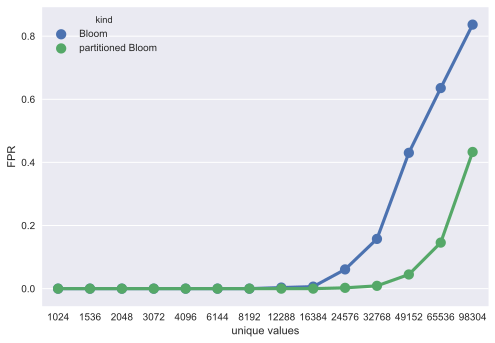

In [21]:
results = []

for pwr in range(10, 17):
    for count in [1 << pwr, (1 << pwr) + (1 << (pwr - 1))]:
        tp, bfp, pbfp = pbloom_experiment(count, 16384, hashes_for(8, 4))
        results.append(("Bloom", count, bfp / (float(tp) + bfp)))
        results.append(("partitioned Bloom", count, pbfp / (float(tp) + pbfp)))
    
df = DataFrame.from_records(results )
df.rename(columns={0: "kind", 1: "unique values", 2: "FPR"}, inplace=True)

ax = sns.pointplot("unique values", "FPR", hue="kind", ci=None, data=df, scatter=True)
_ = ax.set(ylabel="FPR")

### Applications

* The application Bloom used as a case study in [his paper introducing the structure](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.20.2080) was a hyphenation program, in which roughly 90% of words could be hyphenated by simple rules but 10% required a dictionary lookup -- and the dictionary was too large to hold in core.  By using a small Bloom filter to record the words that required dictionary lookup, it would be possible possible to dramatically reduce disk accesses without impacting the correctness of the application.
* [Bloom join](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.134.5196) is a classic technique to optimize joins in distributed databases.  The result of a join is, logically, the subset of the Cartesian product of two relations that satisfies some predicate (typically an equality relation on a field).  There are many strategies for implementing joins in conventional databases, but these may prove prohibitive in a distributed database, where different relations may reside on different machines.  Bloom join optimizes these joins by allowing local filtering of the relations involved.  For example, consider the SQL statement `SELECT * FROM A, B WHERE A.x = B.x`:  by broadcasting Bloom filters of the sets of values for `x` in both `A` and `B`, it is possible to filter out many tuples that would never appe
* Bloom filters are often implemented in hardware, since a range of microarchitectural features can benefit from fast approximate set membership queries.  For one example application, see [Jeffrey and Steffan](http://www.eecg.toronto.edu/~steffan/papers/jeffrey_spaa11.pdf), in which the motivating example involves using Bloom filters to show that two hardware transactions do not interfere before allowing them to commit.  (This technique is not their innovation; rather, the focus of Jeffrey and Steffan's work is to show that _partitioned Bloom filters_ admit a smaller false positive rate for the intersection of Bloom filters, and thus set disjointedness.)

## Count-min sketch

In [22]:
class CMS(object):
    def __init__(self, width, hashes):
        """ Initializes a Count-min sketch with the
            given width and a collection of hashes, 
            which are functions taking arbitrary 
            values and returning integers.  The depth
            of the sketch structure is taken from the
            number of supplied hash functions.
            
            hashes can be either a function taking 
            a value and returning a list of results
            or a list of functions.  In the latter 
            case, this constructor will synthesize 
            the former """
        self.__width = width
        
        if hasattr(hashes, '__call__'):
            self.__hashes = hashes
            # inspect the tuple returned by the hash function to get a depth
            self.__depth = len(hashes(bytes()))
        else:
            funs = hashes[:]
            self.__depth = len(hashes)
            def h(value):
                return [int(f(value)) for f in funs]
            self.__hashes = h
        
        self.__buckets = numpy.zeros((int(width), int(self.__depth)), numpy.uint64)
    
    
    def width(self):
        return self.__width
    
    def depth(self):
        return self.__depth
    
    def insert(self, value):
        """ Inserts a value into this sketch """
        for (row, col) in enumerate(self.__hashes(value)):
            self.__buckets[col % self.__width][row] += 1
    
    def lookup(self, value):
        """ Returns a biased estimate of number of times value has been inserted in this sketch"""
        return min([self.__buckets[col % self.__width][row] for (row, col) in enumerate(self.__hashes(value))])
    
    def merge_from(self, other):
        """ Merges other in to this sketch by 
            adding the counts from each bucket in other
            to the corresponding buckets in this
            
            Updates this. """
        self.__buckets += other.__buckets
    
    def merge(self, other):
        """ Creates a new sketch by merging this sketch's
            counts with those of another sketch. """
        
        cms = CMS(self.width(), self.__hashes)
        cms.__buckets += self.__buckets
        cms.__buckets += other.__buckets
        return cms

    def dup(self):
        cms = CMS(self.width(), self.__hashes)
        cms.merge_from(self)
        return cms

In [23]:
cms = CMS(16384, hashes_for(3,8))

In [24]:
cms.lookup("foo")

0

In [25]:
cms.insert("foo")
cms.lookup("foo")

1

While hash collisions in Bloom filters lead to false positives, hash collisions in count-min sketches lead to overestimating counts.  To see how much this will affect us in practice, we can design an empirical experiment to plot the cumulative distribution of the factors that we've overestimated counts by in sketches of various sizes.

In [26]:
def cms_experiment(sample_count, size, hashes, seed=0x15300625):
    import random
    from collections import namedtuple
   
    random.seed(seed)
    cms = CMS(size, hashes)
    
    result = []
    
    # update the counts
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if i % 100 == 0:
            # every hundredth entry is a heavy hitter
            insert_count = (bits % 512) + 1
        else:
            insert_count = (bits % 8) + 1

        for i in range(insert_count):
            cms.insert(bits)
    
    random.seed(seed)
    # look up the bit sequences again
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if i % 100 == 0:
            # every hundredth entry is a heavy hitter
            expected_count = (bits % 512) + 1
        else:
            expected_count = (bits % 8) + 1

        result.append((int(cms.lookup(bits)), int(expected_count)))
    
    return result

/Users/willb/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


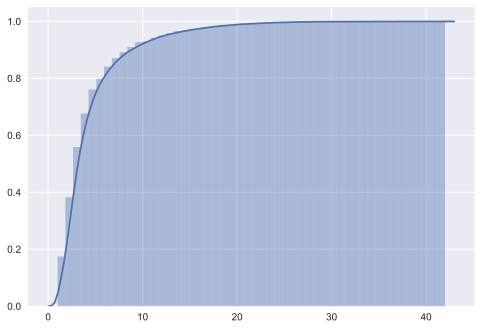

In [27]:
results = cms_experiment(1 << 14, 4096, hashes_for(3, 8))
df = DataFrame.from_records(results)
df.rename(columns={0: "actual count", 1: "expected count"}, inplace=True)
sns.distplot(df["actual count"] / df["expected count"], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

As you can see, about 55% of our counts for this small sketch are overestimated by less than a factor of three, although the worst overestimates are quite large indeed.  Let's try with a larger sketch structure.

/Users/willb/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


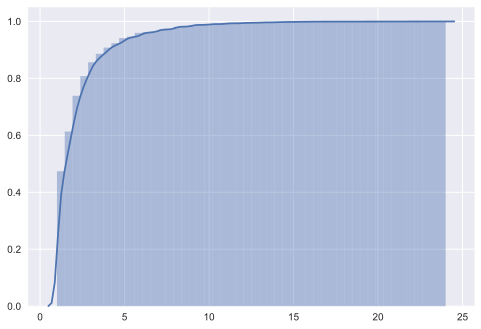

In [29]:
results = cms_experiment(1 << 14, 8192, hashes_for(3, 8))
df = DataFrame.from_records(results)
df.rename(columns={0: "actual count", 1: "expected count"}, inplace=True)

sns.distplot(df["actual count"] / df["expected count"], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

Here are some exercises to try out if you're interested in extending the count-min sketch:

* The count-min sketch is a biased estimator.  Implement a technique to adjust the estimates for expected bias.
* When paired with an auxiliary structure like a priority queue, the count-min sketch can be used to track the top-_k_ event types in a stream.  Try implementing a couple of approaches!



### HyperLogLog

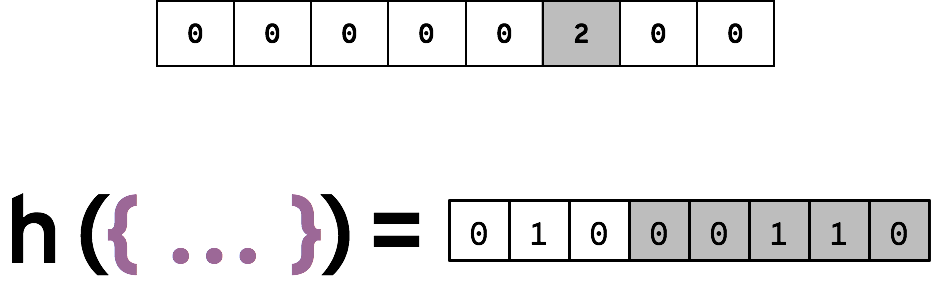

HyperLogLog is the trickiest of these three techniques, so let's start with some intuitions.

If we have a source from which we can sample uniformly-distributed _n_-bit integers, we can also see it as a source for drawing _n_ coin flips -- each bit in an integer sampled from the population of uniformly-distributed _n_-bit integers is independent of the others and is equally likely to be true or false.

Because each bit is independent and equally likely to be true or false, runs of consecutive bits with the same value become increasingly unlikely with length.  The probability of seeing _n_ consecutive zeros, for example, is $1$ in $2^n$.  Similarly, if the largest number of leading zeros we've seen in a stream of random numbers is _n_, we can estimate that we've seen $2^n$ numbers.

To see this in action, let's sample some random numbers and plot the distribution of leading-zero counts.  We'll start with a function to count leading zeros:

In [30]:
def leading_zeros(bs):
    """ Return the index of the leftmost one in an 
        integer represented as an array of bytes """
    first = 0
    for b in bs:
        if b == 0:
            first += 8
        else:
            for bit in range(7, -1, -1):
                if ((1 << bit) & b) > 0:
                    return first
                else:
                    first += 1
    return first

We'll then generate some 32-bit random integers and plot the distribution of leading-zero counts.

/Users/willb/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


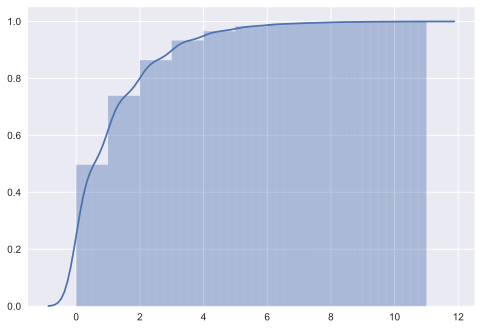

In [31]:
def lz_experiment(ct):
    from numpy.random import randint as ri
    result = []
    for _ in range(ct):
        result.append(leading_zeros(bytes([ri(255), ri(255), ri(255), ri(255)])))

    return result

lz = lz_experiment(4096)

sns.distplot(lz, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

As we can see from inspecting the cumulative distribution plot, about 50% of the samples have no leading zeros, about 75% have one or fewer leading zeros, about 87.5% of samples have two or fewer leading zeros, and so on.

In [183]:
from hashlib import sha1
import pickle

def h64(v):
    bvalue = type(v) == bytes and v or pickle.dumps(v)
    return int.from_bytes(sha1(bvalue).digest()[:8], 'little')

def get_alpha(p):
    return {
        4: 0.673,
        5: 0.697,
        6: 0.709,
    }.get(p, 0.7213 / (1.0 + 1.079 / (1 << p)))

def first_set_bit(i, isize):
    return isize - i.bit_length() + 1

class HLL(object):
    import numpy as np
    def __init__(self, p=4):
        self.p = min(max(p, 4), 12)
        self.m = int(2 ** self.p)
        self.alpha = get_alpha(self.p)
        self._registers = np.zeros(self.m, np.uint8)
        self._zeros = self.m
    
    def add(self, v):
        h = h64(v)
        idx = h & (self.m - 1)
        h >>= self.p
        fsb = first_set_bit(h, 64 - self.p)
        if self._zeros > 0 and self._registers[idx] == 0 and fsb > 0:
            self._zeros -= 1
        self._registers[idx] = max(self._registers[idx], fsb)
    
    def approx_count(self):
        from math import log
        from scipy.stats import hmean
        
        if self._zeros > 0:
            # if we have empty registers (and thus probably a small set),
            # use a different approximation that will be more precise
            return self.m * math.log(float(self.m) / self._zeros)
        else:
            # return the harmonic mean of 2 to the power of every register, 
            # scaled by the number of registers
            return self.alpha * self.m * hmean(np.power(2.0, self._registers))

In [189]:
hll = HLL()

import random

for i in range(20000):
    hll.add(random.getrandbits(64))

hll.approx_count()

20019.621219858156

Like Bloom filters and count-min sketches, HyperLogLog estimates can also be added together so that you can summarize large data sets in parallel.  To combine two HyperLogLog estimates with the same number of registers, simply take the maximum of each pair of registers with the same index.  (As an easy exercise, implement this above and convince yourself that it works the sane as using a single estimate for a large stream.)

If you're interested in learning more about HyperLogLog, a great place to start is ["HyperLogLog in Practice:  Algorithmic Engineering of a State of The Art Cardinality Estimation Algorithm"](https://research.google.com/pubs/pub40671.html).  As an exercise, try implementing some of their techniques to improve the performance of the code above!